In [42]:
import json
import requests
from pathlib import Path
from log import logger
from config import settings


def get_bearer_token() -> str:
    """
    Retrieve a Bearer token from Darey API synchronously.
    """
    url = "https://aiservice.academy.darey.io/ai/api/token"
    headers = {
        "x-business-id": settings.business_id.get_secret_value(),
        "Accept": "application/json",
    }
    payload = {
        "username": settings.darey_username.get_secret_value(),
        "password": settings.darey_password.get_secret_value(),
    }

    try:
        response = requests.post(url, json=payload, headers=headers, timeout=30)
        response.raise_for_status()
        token = response.json()["data"]["access_token"]
        logger.info("Successfully obtained bearer token")
        return token
    except Exception as e:
        logger.error(f"Failed to get bearer token: {e}")
        raise


def download_learners(output_file: str) -> None:
    """
    Download a single page of learners (with settings.download_limit)
    and save to a JSON file.
    """
    try:
        token = get_bearer_token()
        headers = {
            "Authorization": f"Bearer {token}",
            "x-business-id": settings.business_id.get_secret_value(),
            "Accept": "application/json",
        }

        url = f"{settings.download_url}?page=1&limit={settings.download_limit}"
        logger.info(f"Fetching learners from: {url}")

        response = requests.get(url, headers=headers, timeout=120)
        response.raise_for_status()

        data = response.json()
        learners = data.get("data", {}).get("info", [])
        logger.info(f"Fetched {len(learners)} learners")

        Path(output_file).write_text(json.dumps(data, indent=2))
        logger.info(f"Saved learners to {output_file}")

    except Exception as e:
        logger.error(f"Failed to download learners: {e}")
        raise

In [43]:
download_learners("learners.json")

2025-09-01 00:33:31.210 | INFO     | __main__:get_bearer_token:25 - Successfully obtained bearer token
2025-09-01 00:33:31.285 | INFO     | __main__:download_learners:46 - Fetching learners from: https://aiservice.academy.darey.io/ai/api/analytics/fellow-distribution?page=1&limit=50000
2025-09-01 00:34:47.171 | INFO     | __main__:download_learners:53 - Fetched 34753 learners
2025-09-01 00:34:52.066 | INFO     | __main__:download_learners:56 - Saved learners to learners.json


In [44]:
import pandas as pd
from datetime import datetime, timedelta, timezone

# Load JSON and flatten nested 'program_data'
with open("learners.json") as f:
    raw = pd.read_json(f)

learners = pd.json_normalize(raw["data"]["info"])

# Convert date + progress
learners["last_loggedin_date"] = pd.to_datetime(learners["last_loggedin_date"])
learners["progress_status"] = learners["program_data.progress_status"]

# Define cutoff for inactivity
today = datetime.now(timezone.utc)
cutoff = today - timedelta(days=14)

# Initialize category
learners["category"] = "active"  # default

# Assign categories (mutually exclusive)
learners.loc[learners["last_loggedin_date"] < cutoff, "category"] = "inactive"
learners.loc[
    (learners["last_loggedin_date"] >= cutoff) & (learners["progress_status"] < 50),
    "category",
] = "low_progress"
learners.loc[
    (learners["last_loggedin_date"] >= cutoff)
    & (learners["progress_status"] >= 50)
    & (learners["progress_status"] < 100),
    "category",
] = "active"
learners.loc[learners["progress_status"] == 100, "category"] = "completed"

# Build summary DataFrame
summary_df = (
    learners["category"]
    .value_counts(normalize=False)
    .rename_axis("category")
    .reset_index(name="count")
)

# Add percentage column
total = len(learners)
summary_df["percent"] = (summary_df["count"] / total * 100).round(2)

# Append total row
summary_df.loc[len(summary_df)] = ["total_learners", total, 100.0]

summary_df

,category,count,percent
0,active,18512,53.27
1,inactive,12367,35.59
2,completed,3196,9.20
3,low_progress,678,1.95
4,total_learners,34753,100.00


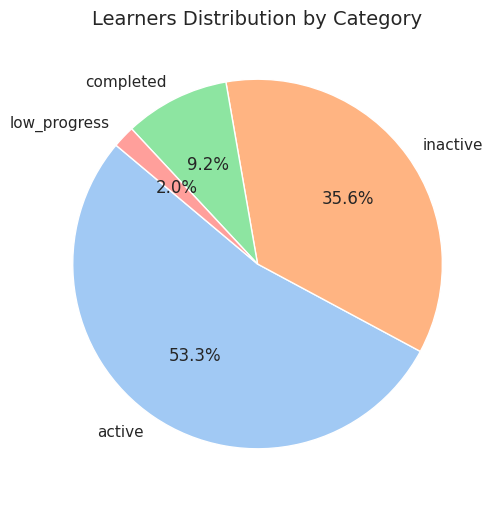

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude the "total_learners" row for plotting
plot_df = summary_df[summary_df["category"] != "total_learners"]

# Apply seaborn theme
sns.set_theme(style="whitegrid")

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    plot_df["count"],
    labels=plot_df["category"],
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("pastel")[0 : len(plot_df)],
)

plt.title("Learners Distribution by Category", fontsize=14)
plt.show()

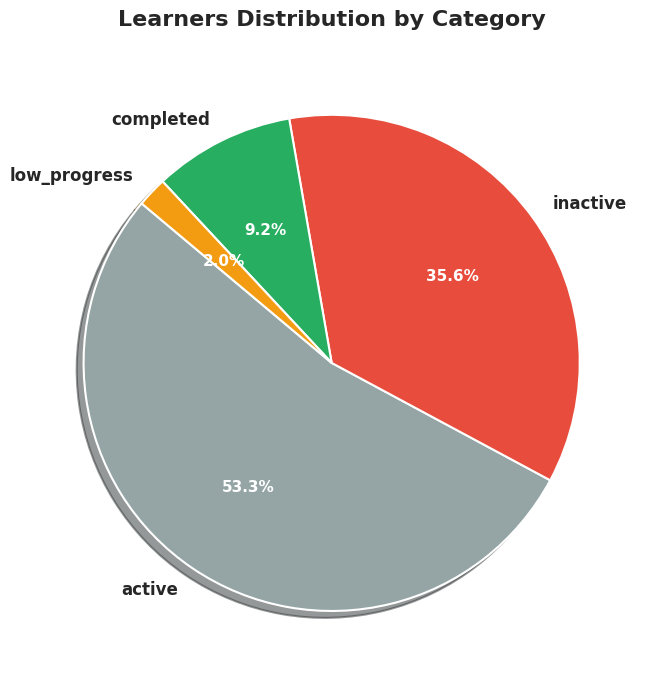

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude the "total_learners" row for plotting
plot_df = summary_df[summary_df["category"] != "total_learners"]

# Define custom color palette (highlight inactive + low_progress)
color_map = {
    "inactive": "#E74C3C",  # strong red
    "low_progress": "#F39C12",  # orange
    "completed": "#27AE60",  # green
    "active": "#95A5A6",  # grey
}
colors = [color_map[cat] for cat in plot_df["category"]]

# Seaborn theme for consistency
sns.set_theme(style="whitegrid")

# Create pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    plot_df["count"],
    labels=plot_df["category"],
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
    shadow=True,
    wedgeprops={"edgecolor": "white", "linewidth": 1.5},
)

# Style labels
for text in texts:
    text.set(size=12, weight="bold")
for autotext in autotexts:
    autotext.set(size=11, weight="bold", color="white")

plt.title("Learners Distribution by Category", fontsize=16, weight="bold", pad=20)
plt.tight_layout()
plt.show()

In [58]:
import plotly.express as px
import plotly.graph_objects as go

# Exclude total row for plotting
plot_df = summary_df[summary_df["category"] != "total_learners"]

# --------------------------
# Donut Chart
# --------------------------
fig_donut = go.Figure(
    data=[
        go.Pie(
            labels=plot_df["category"],
            values=plot_df["count"],
            hole=0.45,
            marker=dict(colors=[colors[c] for c in plot_df["category"]]),
            textinfo="label+percent",
            hovertemplate="<b>%{label}</b><br>Count: %{value}<br>Percent: %{percent}<extra></extra>",
        )
    ]
)

total_learners = int(
    summary_df.loc[summary_df["category"] == "total_learners", "count"].values[0]
)

fig_donut.update_layout(
    title=dict(
        text="Learners Weekly Engagement Breakdown",
        x=0.5,
        xanchor="center",
        font=dict(size=18, color="black", family="Arial Black"),
    ),
    annotations=[
        dict(
            text=f"Total Learners<br>{total_learners}",
            x=0.5,
            y=0.5,
            font_size=14,
            showarrow=False,
        ),
        # Definitions box: moved lower to avoid overlap
        dict(
            text=(
                "<b>Category Definitions</b><br>"
                "🟢 Completed = 100% progress<br>"
                "⚪ Active = login ≤14 days & progress ≥50<br>"
                "🟠 Low Progress = login ≤14 days & progress <50<br>"
                "🔴 Inactive = no login in last 14 days"
            ),
            x=1.18,
            y=0.15,
            xref="paper",
            yref="paper",  # pushed lower
            showarrow=False,
            align="left",
            bordercolor="black",
            borderwidth=1,
            bgcolor="white",
            font=dict(size=11, color="black"),
        ),
    ],
)

fig_donut.write_image("learners_donut.png", scale=3)

# --------------------------
# Bar Chart
# --------------------------
fig_bar = px.bar(
    plot_df,
    x="category",
    y="count",
    color="category",
    text="count",
    color_discrete_map=colors,
    title="Learners Engagement Counts",
)

fig_bar.update_traces(textposition="outside")

fig_bar.update_layout(
    xaxis_title="Category",
    yaxis_title="Number of Learners",
    title=dict(x=0.5, xanchor="center", font=dict(size=18, family="Arial Black")),
    annotations=[
        dict(
            text=(
                "<b>Category Definitions</b><br>"
                "🟢 Completed = 100% progress<br>"
                "⚪ Active = login ≤14 days & progress ≥50<br>"
                "🟠 Low Progress = login ≤14 days & progress <50<br>"
                "🔴 Inactive = no login in last 14 days"
            ),
            x=0.75,
            y=0.95,
            xref="paper",
            yref="paper",  # moved left & up
            showarrow=False,
            align="left",
            bordercolor="black",
            borderwidth=1,
            bgcolor="white",
            font=dict(size=11, color="black"),
        )
    ],
)

fig_bar.write_image("learners_bar.png", scale=3)

In [50]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone

# --------------------------
# Load learners.json
# --------------------------
with open("learners.json", "r") as f:
    learners_data = json.load(f)

learners = learners_data["data"]["info"]
df = pd.DataFrame(learners)

# Convert last login dates
df["last_loggedin_date"] = pd.to_datetime(df["last_loggedin_date"])

# --------------------------
# Categorize learners
# --------------------------
today = datetime.now(timezone.utc)
inactive_mask = df["last_loggedin_date"] < (today - timedelta(days=14))
low_progress_mask = df["program_data"].apply(lambda x: x["progress_status"] < 50)

df["category"] = "Active"
df.loc[inactive_mask, "category"] = "Inactive"
df.loc[~inactive_mask & low_progress_mask, "category"] = "Low Progress"

# Deduplicate learners
df = df.drop_duplicates(subset="_id")

# --------------------------
# Compute email stats
# --------------------------
summary = df["category"].value_counts().to_dict()
inactive_count = summary.get("Inactive", 0)
low_progress_count = summary.get("Low Progress", 0)
emails_per_week = inactive_count + low_progress_count
emails_per_month = emails_per_week * 4
total_learners = len(df)

# --------------------------
# Create infographic figure
# --------------------------
fig = go.Figure()

# Background rectangle (visual card)
fig.add_shape(
    type="rect",
    x0=0,
    x1=1,
    y0=0,
    y1=1,
    xref="paper",
    yref="paper",
    fillcolor="#F0F2F5",
    line=dict(width=0),
    layer="below",
)

# Weekly Emails indicator (big number)
fig.add_trace(
    go.Indicator(
        mode="number",
        value=emails_per_week,
        number={"font": {"size": 80, "color": "#1F77B4"}, "valueformat": ","},
        title={
            "text": f"📩 Weekly Emails<br><span style='font-size:18px;color:gray'>({inactive_count} Inactive + {low_progress_count} Low Progress)</span>"
        },
        domain={"x": [0.1, 0.9], "y": [0.5, 0.9]},
    )
)

# Monthly projection + total learners annotation
fig.add_annotation(
    text=f"Monthly Projection: <b>{emails_per_month:,}</b> emails<br>👥 Total Learners: <b>{total_learners:,}</b>",
    x=0.5,
    y=0.25,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=24, color="#2C3E50"),
    align="center",
)

# Layout for infographic look
fig.update_layout(
    height=600,
    width=800,
    margin=dict(l=20, r=20, t=80, b=20),
    paper_bgcolor="white",
    title_text="3MTT Learner Email Reminder Strategy",
    title_x=0.5,
    title_font=dict(size=28),
)

# Save high-res infographic
fig.write_image("emails_infographic.png", scale=3)

print("✅ Emails infographic saved as emails_infographic.png")
print(f"- Weekly emails: {emails_per_week}")
print(f"- Monthly emails: {emails_per_month}")
print(f"- Total learners: {total_learners}")

✅ Emails infographic saved as emails_infographic.png
- Weekly emails: 33074
- Monthly emails: 132296
- Total learners: 34753


In [52]:
import json
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone

# --------------------------
# Load learners.json
# --------------------------
with open("learners.json", "r") as f:
    learners_data = json.load(f)

learners = learners_data["data"]["info"]
df = pd.DataFrame(learners)

# Convert last login dates
df["last_loggedin_date"] = pd.to_datetime(df["last_loggedin_date"])
df["progress_status"] = df["program_data"].apply(lambda x: x["progress_status"])

# --------------------------
# Categorize learners (Script 1 logic)
# --------------------------
today = datetime.now(timezone.utc)
cutoff = today - timedelta(days=14)

df["category"] = "active"  # default

# Completed first
df.loc[df["progress_status"] == 100, "category"] = "completed"

# Inactive (only among not completed)
df.loc[
    (df["progress_status"] < 100) & (df["last_loggedin_date"] < cutoff), "category"
] = "inactive"

# Low progress (active but <50%)
df.loc[
    (df["progress_status"] < 50)
    & (df["last_loggedin_date"] >= cutoff)
    & (df["progress_status"] < 100),
    "category",
] = "low_progress"

# Active (50–99%, recent login)
df.loc[
    (df["progress_status"] >= 50)
    & (df["progress_status"] < 100)
    & (df["last_loggedin_date"] >= cutoff),
    "category",
] = "active"

# Deduplicate learners
df = df.drop_duplicates(subset="_id")

# --------------------------
# Compute stats
# --------------------------
inactive_count = (df["category"] == "inactive").sum()
low_progress_count = (df["category"] == "low_progress").sum()
active_incl_low = (
    (df["category"] == "active") | (df["category"] == "low_progress")
).sum()
completed_count = (df["category"] == "completed").sum()
total_learners = len(df)

emails_per_week = inactive_count + low_progress_count
emails_per_month = emails_per_week * 4

# --------------------------
# Create infographic figure
# --------------------------
fig = go.Figure()

# Background rectangle (visual card)
fig.add_shape(
    type="rect",
    x0=0,
    x1=1,
    y0=0,
    y1=1,
    xref="paper",
    yref="paper",
    fillcolor="#F0F2F5",
    line=dict(width=0),
    layer="below",
)

# Weekly Emails indicator (big number at top)
fig.add_trace(
    go.Indicator(
        mode="number",
        value=emails_per_week,
        number={"font": {"size": 80, "color": "#1F77B4"}, "valueformat": ","},
        title={
            "text": f"📩 Weekly Emails<br>"
            f"<span style='font-size:18px;color:gray'>({inactive_count} Inactive + {low_progress_count} Low Progress)</span>"
        },
        domain={"x": [0.1, 0.9], "y": [0.65, 1.0]},
    )
)

# Annotations stacked neatly below
fig.add_annotation(
    text=f"Monthly Projection: <b>{emails_per_month:,}</b> emails",
    x=0.5,
    y=0.35,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=24, color="#2C3E50"),
    align="center",
)

fig.add_annotation(
    text=f"👥 Total Learners: <b>{total_learners:,}</b>",
    x=0.5,
    y=0.25,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=22, color="#2C3E50"),
    align="center",
)

fig.add_annotation(
    text=f"Breakdown → Active incl. Low: {active_incl_low}, Inactive: {inactive_count}, Completed: {completed_count}",
    x=0.5,
    y=0.15,
    xref="paper",
    yref="paper",
    showarrow=False,
    font=dict(size=18, color="gray"),
    align="center",
)

# Layout polish
fig.update_layout(
    height=650,
    width=850,
    margin=dict(l=20, r=20, t=80, b=20),
    paper_bgcolor="white",
    title_text="3MTT Learner Email Reminder Strategy",
    title_x=0.5,
    title_font=dict(size=28),
)

# Save high-res infographic
fig.write_image("emails_infographic.png", scale=3)

print("✅ Emails infographic saved as emails_infographic.png")
print(f"- Weekly emails: {emails_per_week}")
print(f"- Monthly emails: {emails_per_month}")
print(f"- Total learners: {total_learners}")

✅ Emails infographic saved as emails_infographic.png
- Weekly emails: 13065
- Monthly emails: 52260
- Total learners: 34753


In [37]:
import inspect

In [38]:
inspect.get_annotations(download_learners)

{'output_file': str, 'return': None}

In [39]:
inspect.get_annotations(get_bearer_token)

{'return': str}

In [41]:
inspect.getsource(download_learners)

'def download_learners(output_file: str) -> None:\n    """\n    Download a single page of learners (with settings.download_limit)\n    and save to a JSON file.\n    """\n    try:\n        token = get_bearer_token()\n        headers = {\n            "Authorization": f"Bearer {token}",\n            "x-business-id": settings.business_id.get_secret_value(),\n            "Accept": "application/json",\n        }\n\n        url = f"{settings.download_url}?page=1&limit={settings.download_limit}"\n        logger.info(f"Fetching learners from: {url}")\n\n        response = requests.get(url, headers=headers, timeout=120)\n        response.raise_for_status()\n\n        data = response.json()\n        learners = data.get("data", {}).get("info", [])\n        logger.info(f"Fetched {len(learners)} learners")\n\n        Path(output_file).write_text(json.dumps(data, indent=2))\n        logger.info(f"Saved learners to {output_file}")\n\n    except Exception as e:\n        logger.error(f"Failed to downloa